## Analysis of Uncertainty on SR student model
Debugging selected sentences with:
<docid> <sentence> <student sentence label> <student sentence probability> <oracle sentence label> <true document label>

What type of snippets are being selected by random and SR? 

* compute the student's uncertainty for each document that is to be labeled. 
* Plot the distribution of these values, split by whether the label is correct/incorrect. 
* Check rnd-sr for a larger spike of incorrect labels for uncertain documents
    * Then this would indicate that more useful documents are being assigned the wrong label (assuming uncertainty is a good utility measure).


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import ast
mpl.style.use('bmh')

#load data of SR
sr_file = 'data-imdb-lrn-sequential-ut-rnd-snip-sr-cal-True.txt'
#load data of RND
rnd_file = 'data-imdb-lrn-sequential-ut-rnd-snip-rnd-cal-False.txt'

def read_data(filename):
    f = open(filename)
    with f:
        lines = f.readlines() 
    data =  [l.strip().split("\t")[:6] for l in lines[1:]]
    text =  np.array([l.strip().split("\t")[-1] for l in lines[1:]])

    data = np.array([[float(x) for x in row] for row in data])
    return data, text

#docid, target,student-y0,student-y1,expert-y0,expert-y1,snippet
sr,sr_text = read_data(sr_file)
rnd,rnd_text = read_data(rnd_file)

In [5]:
def get_uncertainty(data, type='student'):
    if type=='student':
        probs = data[:,[2,3]]
    else:
        probs = data[:,[4,5]]
    unc = 1 - probs.max(axis=1)
    return unc

def f(x):
    if x > .5:
        return 0
    else: 
        return 1
    
unc_stu_sr = get_uncertainty(sr,type='student')
unc_exp_sr = get_uncertainty(sr,type='expert')
pred_stu_sr = [f(x) for x in sr[:,2]]
correct_st_sr = pred_stu_sr == sr[:,1]
print sr[:3, [2,3]]
print unc_stu_sr[:3]
        
    

[[ 0.73420436  0.26579564]
 [ 0.50167503  0.49832497]
 [ 0.58917482  0.41082518]]
[ 0.26579564  0.49832497  0.41082518]


Incorrect: 323, Correct: 677


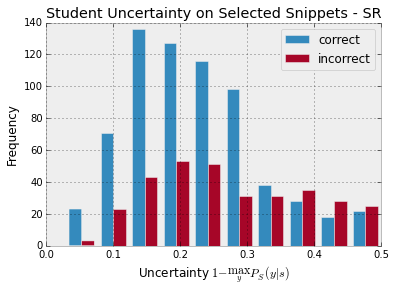

In [6]:
def plot_uncertainty(unc, correct, title, stacked=False):
    n  = plt.hist([unc[correct],unc[-correct]],  bins=10, stacked=stacked,
             label=['correct','incorrect'])
    plt.title("Student Uncertainty on Selected Snippets - "+ title)
    plt.xlabel('Uncertainty $1 - \max_{y}P_S(y|s)$')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig("unc-"+title+".png")
    return n
n_sr = plot_uncertainty(unc_stu_sr[:1000], correct_st_sr[:1000], "SR")
print "Incorrect: %s, Correct: %s" % (len(unc_stu_sr[-correct_st_sr[:1000]]), len(unc_stu_sr[correct_st_sr[:1000]]))

Incorrect: 244, Correct: 756


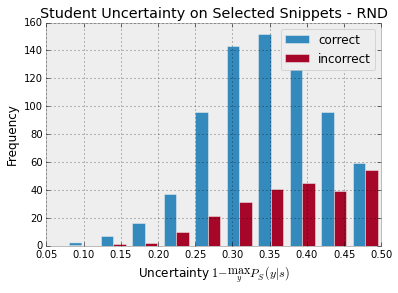

In [7]:
unc_stu_rnd = get_uncertainty(rnd,type='student')
unc_exp_rnd = get_uncertainty(rnd,type='expert')
pred_stu_rnd = [f(x) for x in rnd[:,2]]
correct_st_rnd = pred_stu_rnd == rnd[:,1]
n_rnd= plot_uncertainty(unc_stu_rnd[:1000], correct_st_rnd[:1000], "RND")
print "Incorrect: %s, Correct: %s" % (len(unc_stu_rnd[-correct_st_rnd[:1000]]), len(unc_stu_rnd[correct_st_rnd[:1000]]))

In [8]:
# plot_uncertainty(unc_stu_rnd[1000:2000], correct_st_rnd[1000:2000], "RND")
# plot_uncertainty(unc_stu_rnd[2000:3000], correct_st_rnd[2000:3000], "RND")

# Text of the good and bad snippets 
def incorrect_text(unc, correct, text, top=10):
    i = 0
    for u, c, t in zip(unc[:top], correct[:top], text[:top]):
        if c == False and u <.25:
            print "%.3f\t%s\t%s" %(u ,c, t)
            i+=1
    print "Total:", i
print "Random - Errors"
incorrect_text(unc_stu_rnd, correct_st_rnd, rnd_text, top=10)
print "\nSR_CAL - Errors"
incorrect_text(unc_stu_sr, correct_st_sr, sr_text, top=10)



Random - Errors
Total: 0

SR_CAL - Errors
Total: 0


In [9]:
order = np.argsort(unc_stu_sr[:1000])[::-1]
for a,b,c,t in zip(unc_stu_sr[order], unc_exp_sr[order], correct_st_sr[order], sr_text[order])[:20]:
    if a >.4 and  c == False:
        print "%.3f\t%.3f\t%s\t%s" % (a, b,c,t)

0.500	0.390	False	The scenes are fast-paced.
0.499	0.148	False	Not for everyone, this film details Hanzo's investigation of loan sharking being performed by an order of blind monks.
0.498	0.493	False	Imagine a movie where Joe Piscopo is actually funny!
0.498	0.088	False	Passport to Pimlico is a real treat for all fans of British cinema.
0.497	0.239	False	Jaco van Dormael does a wonderful job with the script and direction.
0.496	0.152	False	Witherspoon already begins to show the Oscar-winning talent she would develop in this early role and London makes a charming leading man.
0.494	0.229	False	All the songs are great, and actually memorable, unlike many children's musicals, where the songs are just stuck in for no real reason.
0.487	0.329	False	Even seeing a few seconds of it would bring back that feeling of magic and warm my heart.


In [10]:
from scipy.stats import pearsonr
print pearsonr(unc_stu_sr[order], unc_exp_sr[order])

(0.33431501899191401, 1.5479750899977733e-27)


In [11]:
tmp = unc_stu_sr[:1000]
print tmp[:3]
print "Uncertain > .4: ", len(tmp[tmp > .4]), 60./len(tmp[tmp >.4]) 
tmp = unc_stu_rnd[:1000]
print "Rnd uncertain > .4", len(tmp[tmp >.4]),  110./len(tmp[tmp >.4])


[ 0.26579564  0.49832497  0.41082518]
Uncertain > .4:  107 0.560747663551
Rnd uncertain > .4 319 0.344827586207


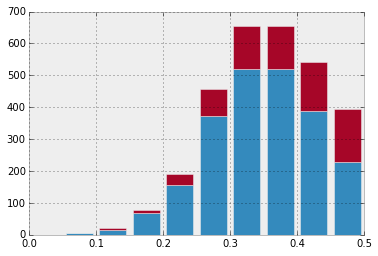

In [12]:
counts = plt.hist([unc_stu_rnd[correct_st_rnd],unc_stu_rnd[-correct_st_rnd]],  bins=np.arange(0,.501,.05), stacked=True,
             label=['correct','incorrect'])

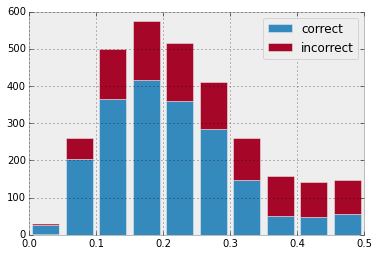

In [13]:
counts = plt.hist([unc_stu_sr[correct_st_sr],unc_stu_sr[-correct_st_sr]],  bins=np.arange(0,.501,.05), stacked=True,
             label=['correct','incorrect'])
plt.legend(loc='best')

## Corrected Histograms - Accuracy

Add accuracy of each bin. What bin is more accurate?

**Histogram Graph**

This graph shows the number of examples in each bin of uncertainty split by correct and incorrect labels (according to the student label).

**Accuracy Graph**

This graph shows the accuracy inside each bin of the histogram bar. The error bars of this graph is the standard deviation of the bin. 

**Notes**

* SR accuracy is in general lower than RND
* Accuracy of SR is bad for high values of uncertainty, whereas RND performs better
* When indoubt pick random sentences? 


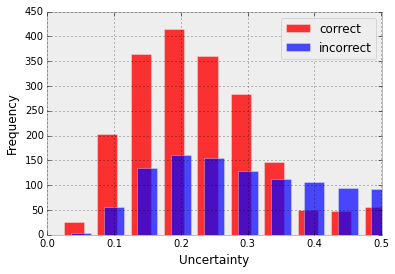

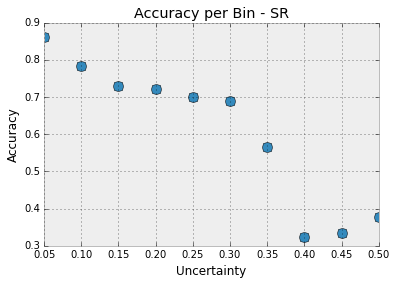

In [14]:
def histogram_uncertainty_correct(unc, correct):
    """Plot distribution of uncertainty by correct and incorrect labels"""
    cor,binEdges =np.histogram(unc[correct],bins=np.arange(0,.501,.05))
    incor,_      =np.histogram(unc[-correct],bins=np.arange(0,.501,.05))
    bincenters   = 0.5*(binEdges[1:]+binEdges[:-1])
    
    width=0.03
    plt.bar(bincenters,cor,width=width, color='r',  alpha=.8, label='correct')
    plt.bar(bincenters+0.01,incor,width=width, color='b', alpha=.7, label='incorrect')
    plt.legend(loc='best')
    plt.xlabel("Uncertainty")
    plt.xlim([0,.501])
    plt.ylabel('Frequency')
    plt.show()
    return cor,incor, bincenters

from scipy import stats
def accu_corr(cor,incor, title, bincenters):
    '''Plot accuracy per error bar bin'''
    accu_st = np.array([np.mean(x) for x in [[1]*cr + [0]*inc for cr, inc in zip(cor,incor)]])
    plt.errorbar(bincenters+0.025, accu_st, ls="", markersize=10, marker="o")
    plt.title("Accuracy per Bin - " + title)
    plt.xlabel("Uncertainty")
    plt.ylabel("Accuracy")
    plt.show()

cor, incor, binc = histogram_uncertainty_correct(unc_stu_sr, correct_st_sr)
accu_corr(cor,incor, "SR" , binc)


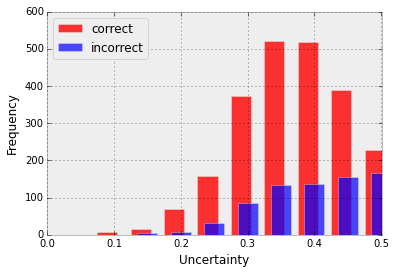

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


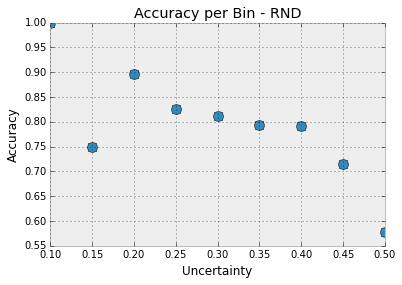

In [15]:
cor, incor, binc = histogram_uncertainty_correct(unc_stu_rnd, correct_st_rnd)
accu_corr(cor,incor, "RND", binc)

### Notes: Corrected Histograms

From the corrected histograms we see that the more uncertain the lower the accuracy, this holds for both methods (RND and SR). However, when SR is more uncertain the accuracy is a lot lower compared to RND.


## Uncertainty of the Expert

Uncertainty of the expert on the selected setences of the documents


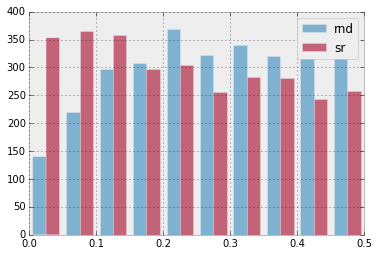

In [23]:
#docid, target,student-y0,student-y1,expert-y0,expert-y1,snippet

plt.hist([unc_exp_rnd,unc_exp_sr], bins=10,  alpha=.6, label=['rnd', 'sr'])
plt.legend(loc='best')

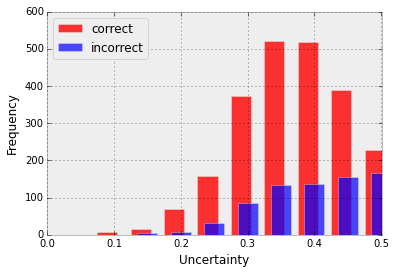

In [26]:
#docid, target,student-y0,student-y1,expert-y0,expert-y1,snippet
rank_file = 'data-imdb-lrn-sequential-ut-rnd-snip-sr_rank-cal-True.txt'
rank,rank_text = read_data(rank_file)

unc_exp_rank = get_uncertainty(rank,type='expert')

pred_exp_rank = [f(x) for x in rank[:,4]]
correct_ex_rank = pred_exp_rank == rank[:,1]

cor, incor, binc = histogram_uncertainty_correct(unc_stu_rnd, correct_st_rnd)


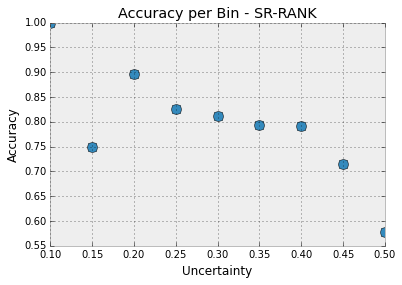

In [27]:
accu_corr(cor,incor, "SR-RANK", binc)

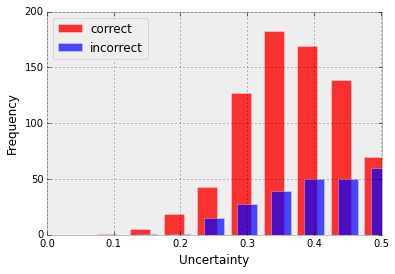

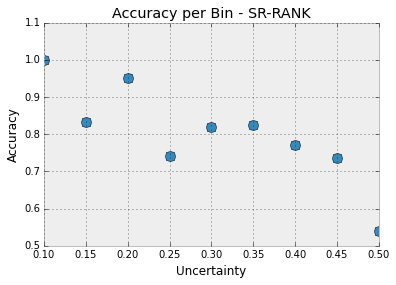

In [29]:
cor, incor, binc = histogram_uncertainty_correct(unc_stu_rnd[:1000], correct_st_rnd[:1000])
accu_corr(cor,incor, "SR-RANK", binc)

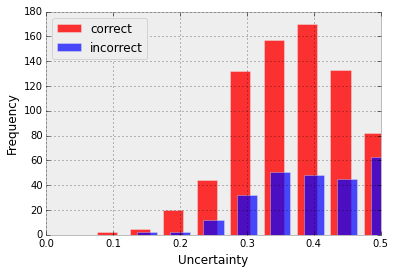

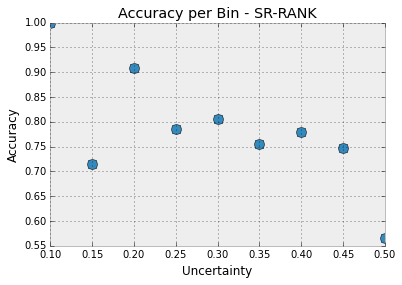

In [30]:
cor, incor, binc = histogram_uncertainty_correct(unc_stu_rnd[1000:2000], correct_st_rnd[1000:2000])
accu_corr(cor,incor, "SR-RANK", binc)

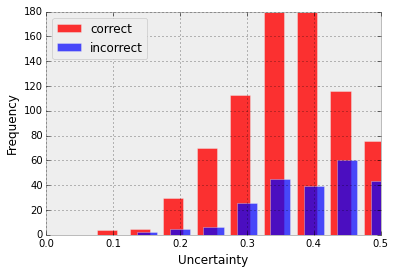

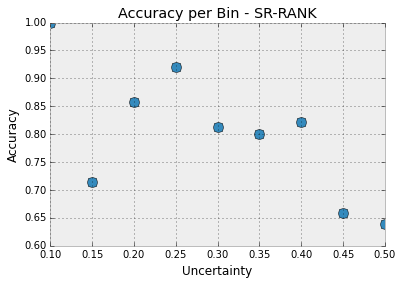

In [31]:
cor, incor, binc = histogram_uncertainty_correct(unc_stu_rnd[2000:3000], correct_st_rnd[2000:3000])
accu_corr(cor,incor, "SR-RANK", binc)